## Import Functions

In [750]:
import pandas as pd
import matplotlib.pyplot as plt

def read_reward_column(csv_file_path, reward_column="reward", action_column="action", max_steps=None, window_size=64):
    """
    Reads a CSV file, extracts the reward and action columns, and visualizes them in a scatter plot.
    Includes a moving average of the reward trend.
    
    Parameters:
    - csv_file_path (str): Path to the CSV file.
    - reward_column (str): Name of the column containing rewards.
    - action_column (str): Name of the column containing actions.
    - max_steps (int, optional): Maximum number of steps to plot.
    - window_size (int): Window size for the moving average.
    
    Displays a scatter plot with a reward trend line, moving average, and color-coded actions.
    """

    # Read the CSV file
    data = pd.read_csv(csv_file_path)

    # Validate columns
    if reward_column not in data.columns:
        raise ValueError(f"Column '{reward_column}' not found in the CSV file.")
    if action_column not in data.columns:
        raise ValueError(f"Column '{action_column}' not found in the CSV file.")
    
    # Limit steps if specified
    if max_steps is not None:
        data = data.iloc[:max_steps]

    rewards = data[reward_column]
    actions = data[action_column]

    # Compute moving average
    moving_avg = rewards.rolling(window=window_size, min_periods=1).mean()

    # Define color mapping for actions
    def get_action_color(action):
        if 0 <= action <= 4:
            return 'green'  # Add model
        elif 5 <= action <= 9:
            return 'red'  # Remove model
        elif action == 10:
            return 'blue'  # Keep ensemble
        return 'gray'  # Unknown action

    colors = [get_action_color(action) for action in actions]

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot the raw reward trend
    plt.plot(range(len(rewards)), rewards, linestyle='-', color='black', alpha=0.3, label="Reward Trend")

    # Plot moving average of the reward
    plt.plot(range(len(moving_avg)), moving_avg, linestyle='-', color='orange', linewidth=2, label=f"Moving Avg (Window={window_size})")

    # Overlay scatter plot with action-based colors
    plt.scatter(range(len(rewards)), rewards, c=colors, alpha=0.7, label="Reward Values")

    # Create legend
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=label)
        for color, label in zip(["green", "red", "blue"], ["Add Model (0-4)", "Remove Model (5-9)", "Keep Ensemble (10)"])
    ]
    plt.legend(handles=legend_handles + [plt.Line2D([0], [0], color='orange', linewidth=2, label="Moving Average")], 
               title="Actions", loc="upper left")

    # Customize plot
    plt.title(f'{reward_column} Plot with Moving Average')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.grid(True)

    # Show the plot
    plt.show()



In [751]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_average_per_chunk(csv_file_path, reward_column="reward", action_column="action", chunk_size=128):
    """
    Reads a CSV file, computes the average of the reward column for every specified chunk of rows,
    and visualizes the results in a plot.

    Parameters:
    - csv_file_path (str): Path to the CSV file.
    - reward_column (str): Name of the column containing rewards.
    - action_column (str): Name of the column containing actions.
    - chunk_size (int): Number of rows per chunk to compute the average.

    Displays a plot with the average reward per chunk.
    """

    # Read the CSV file
    data = pd.read_csv(csv_file_path)

    # Validate columns
    if reward_column not in data.columns:
        raise ValueError(f"Column '{reward_column}' not found in the CSV file.")
    if action_column not in data.columns:
        raise ValueError(f"Column '{action_column}' not found in the CSV file.")

    # Group data into chunks and compute the mean for each chunk
    chunked_data = data.groupby(data.index // chunk_size).mean()

    # Extract the averaged rewards and actions
    avg_rewards = chunked_data[reward_column]
    avg_actions = chunked_data[action_column]

    # Define color mapping for actions
    def get_action_color(action):
        if 0 <= action <= 4:
            return 'green'  # Add model
        elif 5 <= action <= 9:
            return 'red'  # Remove model
        elif action == 10:
            return 'blue'  # Keep ensemble
        return 'gray'  # Unknown action

    colors = [get_action_color(action) for action in avg_actions]

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot the averaged rewards
    plt.plot(range(len(avg_rewards)), avg_rewards, linestyle='-', color='orange', linewidth=2, label=f"Average Reward per {chunk_size} Steps")

    # Overlay scatter plot with action-based colors
    plt.scatter(range(len(avg_rewards)), avg_rewards, c=colors, alpha=0.7, label="Average Reward Values")

    # Create legend
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=label)
        for color, label in zip(["green", "red", "blue"], ["Add Model (0-4)", "Remove Model (5-9)", "Keep Ensemble (10)"])
    ]
    plt.legend(handles=legend_handles + [plt.Line2D([0], [0], color='orange', linewidth=2, label="Average Reward per Chunk")],
               title="Actions", loc="upper left")

    # Customize plot
    plt.title(f'Average {reward_column.capitalize()} per {chunk_size} Steps')
    plt.xlabel('Chunk Index')
    plt.ylabel('Average Reward')
    plt.grid(True)

    # Show the plot
    plt.show()


In [752]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

def plot_average_per_chunk_with_stats(csv_file_path, reward_column="reward", action_column="action", chunk_size=128):
    """
    Reads a CSV file, computes the average of the reward column for every specified chunk of rows,
    fits a linear regression model to the averaged rewards, and visualizes the results in a plot.
    Additionally, provides a statistical summary of the regression model.

    Parameters:
    - csv_file_path (str): Path to the CSV file.
    - reward_column (str): Name of the column containing rewards.
    - action_column (str): Name of the column containing actions.
    - chunk_size (int): Number of rows per chunk to compute the average.

    Displays a plot with the average reward per chunk and the fitted regression line.
    Prints the statistical summary of the regression model.
    """

    # Read the CSV file
    data = pd.read_csv(csv_file_path)

    # Validate columns
    if reward_column not in data.columns:
        raise ValueError(f"Column '{reward_column}' not found in the CSV file.")
    if action_column not in data.columns:
        raise ValueError(f"Column '{action_column}' not found in the CSV file.")

    # Group data into chunks and compute the mean for each chunk
    chunked_data = data.groupby(data.index // chunk_size).mean()

    # Extract the averaged rewards and actions
    avg_rewards = chunked_data[reward_column]
    avg_actions = chunked_data[action_column]

    # Define color mapping for actions
    def get_action_color(action):
        if 0 <= action <= 4:
            return 'green'  # Add model
        elif 5 <= action <= 9:
            return 'red'  # Remove model
        elif action == 10:
            return 'blue'  # Keep ensemble
        return 'gray'  # Unknown action

    colors = [get_action_color(action) for action in avg_actions]

    # Prepare data for linear regression using statsmodels
    X = np.arange(len(avg_rewards))  # Chunk indices as the independent variable
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    y = avg_rewards.values  # Averaged rewards as the dependent variable

    # Fit the linear regression model using statsmodels
    model = sm.OLS(y, X).fit()

    # Print the statistical summary
    print(model.summary())

    # Predict the trend line
    trend_line = model.predict(X)

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot the averaged rewards
    plt.plot(X[:, 1], avg_rewards, linestyle='-', color='orange', linewidth=2, label=f"Average Reward per {chunk_size} Steps")

    # Overlay scatter plot with action-based colors
    plt.scatter(X[:, 1], avg_rewards, c=colors, alpha=0.7, label="Average Reward Values")

    # Plot the linear regression trend line
    plt.plot(X[:, 1], trend_line, linestyle='--', color='blue', linewidth=2, label="Linear Regression Trend Line")

    # Create legend
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=label)
        for color, label in zip(["green", "red", "blue"], ["Add Model (0-4)", "Remove Model (5-9)", "Keep Ensemble (10)"])
    ]
    plt.legend(handles=legend_handles + [
        plt.Line2D([0], [0], color='orange', linewidth=2, label="Average Reward per Chunk"),
        plt.Line2D([0], [0], color='blue', linestyle='--', linewidth=2, label="Linear Regression Trend Line")
    ], title="Actions", loc="upper left")

    # Customize plot
    plt.title(f'Average {reward_column.capitalize()} per {chunk_size} Steps with Regression Trend Line')
    plt.xlabel('Chunk Index')
    plt.ylabel('Average Reward')
    plt.grid(True)

    # Show the plot
    plt.show()


## Reading the data

In [753]:
csv_file_path = "results/ppo/reinforcement_learning_acc_1302.csv"

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     32.59
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           2.06e-05
Time:                        00:12:26   Log-Likelihood:                 25.705
No. Observations:                  20   AIC:                            -47.41
Df Residuals:                      18   BIC:                            -45.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2624      0.030      8.633      0.0

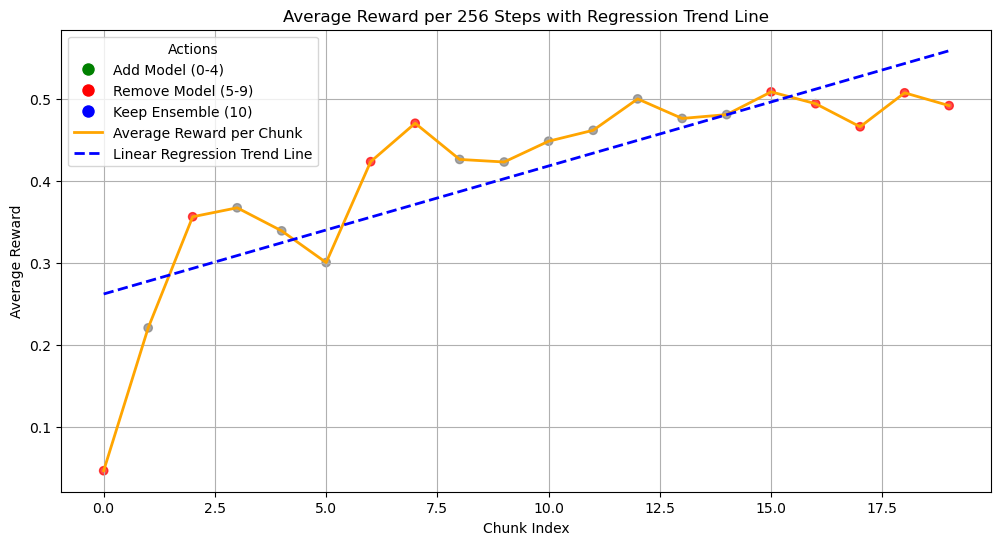

In [754]:
plot_average_per_chunk_with_stats(csv_file_path, chunk_size= 256)

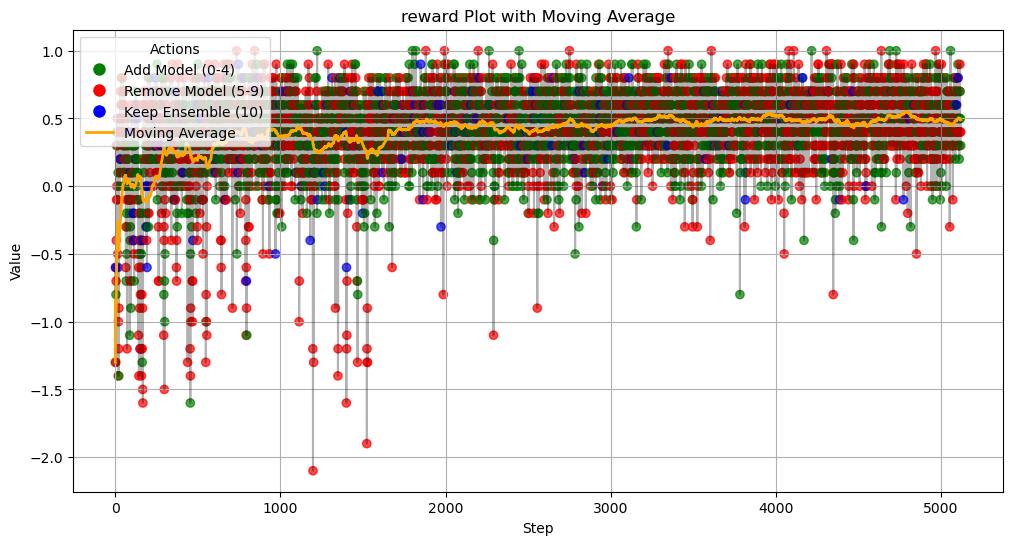

In [755]:
read_reward_column(csv_file_path, "reward", window_size=128)

### In more detail

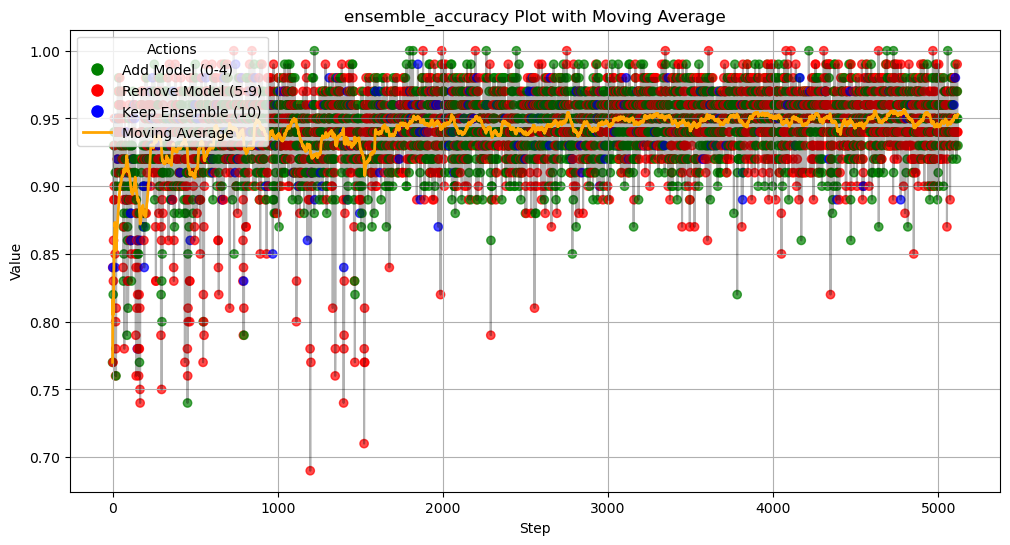

In [756]:
read_reward_column(csv_file_path, "ensemble_accuracy")

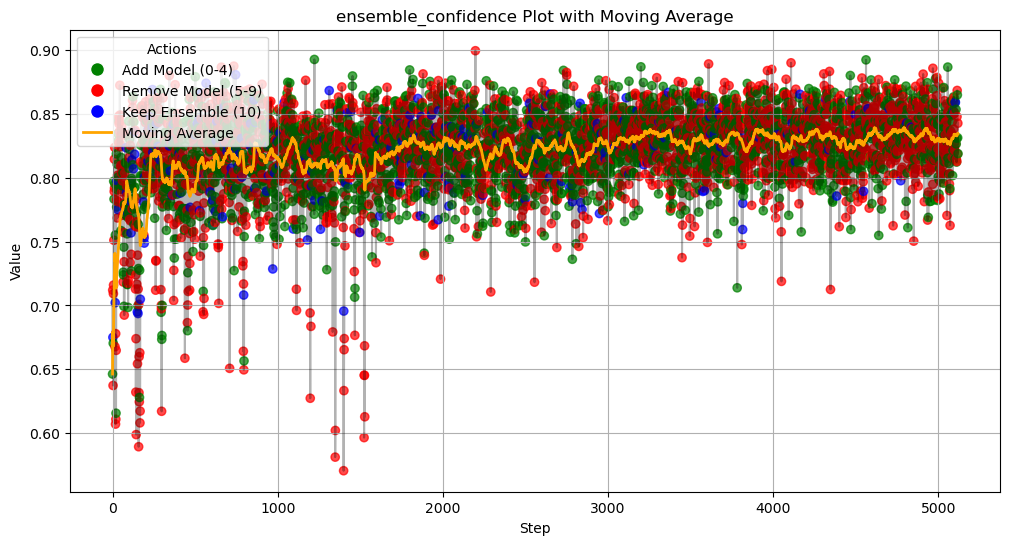

In [757]:
read_reward_column(csv_file_path, "ensemble_confidence")

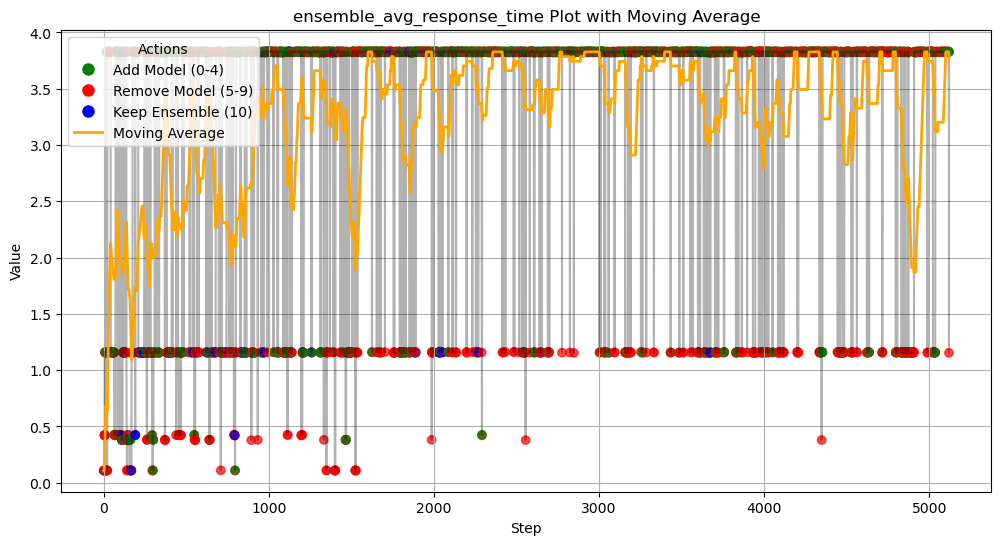

In [758]:
read_reward_column(csv_file_path, "ensemble_avg_response_time")

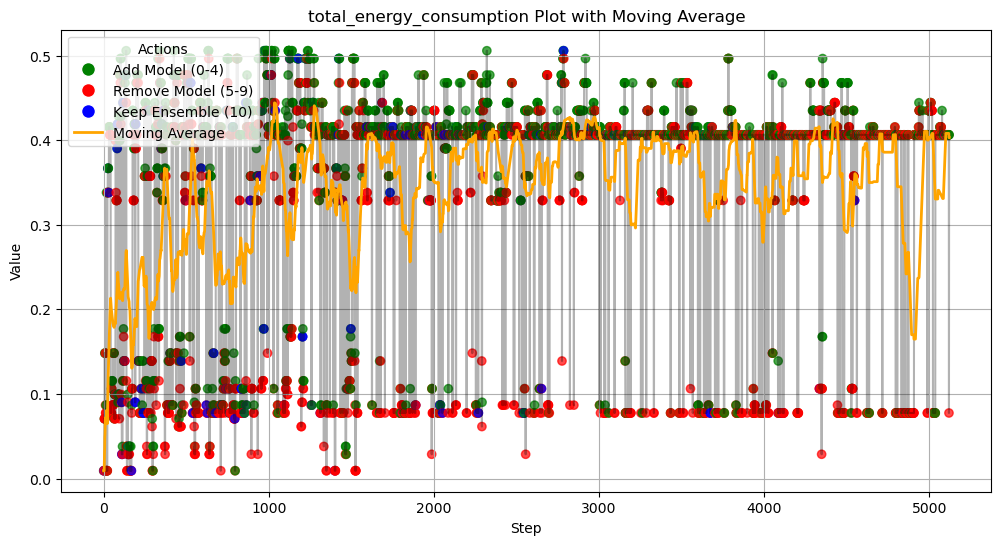

In [759]:
read_reward_column(csv_file_path, "total_energy_consumption")

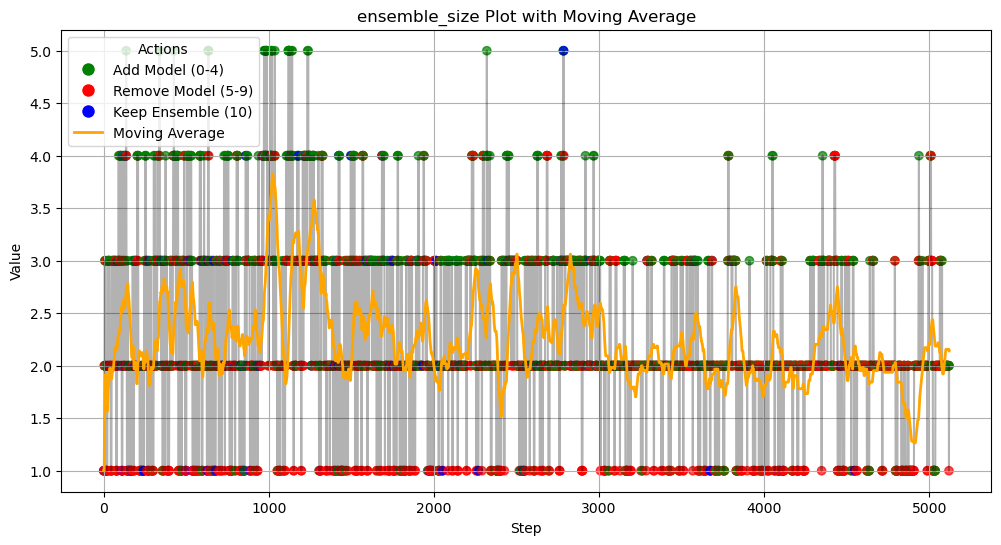

In [760]:
read_reward_column(csv_file_path, "ensemble_size")

### Distance from the ideal ensemble

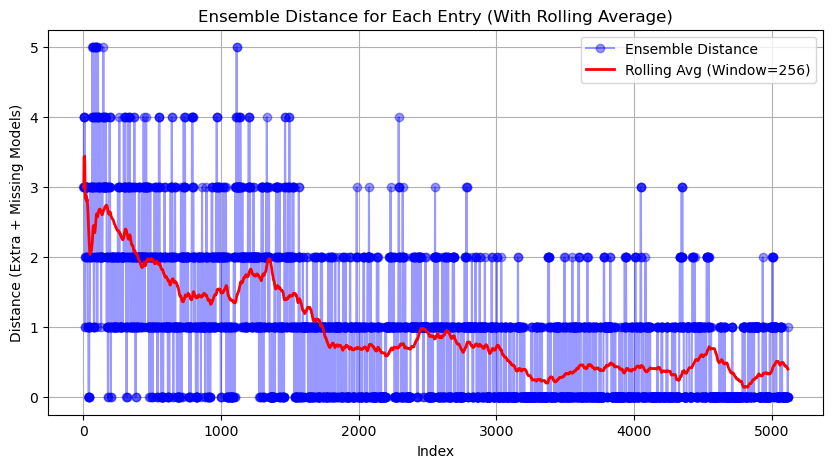

,total_energy_consumption,ensemble_size,input_file_length,image_height,image_width,ensemble_accuracy,ensemble_confidence,ensemble_avg_response_time,ensemble_max_response_time,ensemble_contribution,reward,action,distribution_weights,models,Ensemble_Distance,Rolling_Ensemble_Distance
0,0.009259,1,15,224,224,0.77,0.646311,0.106494,0.143962,0.701116,-1.3,2,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",['MobileNetV2'],3,3.000000
1,0.009259,1,14,224,224,0.84,0.712016,0.109601,0.168433,0.780096,-0.6,5,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",['MobileNetV2'],3,3.000000
2,0.009259,1,14,224,224,0.84,0.675026,0.108101,0.136018,0.699856,-0.6,10,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",['MobileNetV2'],3,3.000000
3,0.009259,1,14,224,224,0.77,0.637322,0.108617,0.136402,0.705069,-1.3,9,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",['MobileNetV2'],3,3.000000
4,0.070713,2,15,224,224,0.82,0.670420,0.422192,0.461982,0.816586,-0.8,4,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","['MobileNetV2', 'ResNet50']",4,3.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5115,0.406273,2,15,224,224,0.97,0.864929,3.830896,4.022407,0.909825,0.7,1,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","['EfficientNetV2S', 'NASNetLarge']",0,0.414062
5116,0.406273,2,14,224,224,0.94,0.818763,3.829357,3.955191,0.866140,0.4,9,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","['EfficientNetV2S', 'NASNetLarge']",0,0.410156
5117,0.406273,2,15,224,224,0.95,0.831357,3.831169,4.006652,0.890034,0.5,3,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","['EfficientNetV2S', 'NASNetLarge']",0,0.406250
5118,0.077517,1,13,224,224,0.94,0.842751,1.154060,1.216141,0.865026,0.4,8,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",['EfficientNetV2S'],1,0.406250


In [762]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

def compute_ensemble_distance(df, column_name, ideal_ensemble, window_size=10):
    """
    Computes the ensemble distance (difference between actual and ideal ensemble),
    and plots the distance along with a rolling average.

    Parameters:
    - df (pd.DataFrame): Input dataframe.
    - column_name (str): Column name containing the ensemble model lists.
    - ideal_ensemble (list): List of ideal model names.
    - window_size (int): Window size for rolling average.

    Returns:
    - df (pd.DataFrame): Updated dataframe with "Ensemble_Distance" column.
    """

    # Ensure column exists
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    # Convert ideal ensemble to a set (extract model names only)
    ideal_set = set(ideal_ensemble)
    distances = []

    for models in df[column_name]:
        model_list = ast.literal_eval(models)  # Convert string to list

        actual_set = set(model_list)

        # Compute extra and missing models
        extra_models = len(actual_set - ideal_set)  # Models in actual but not in ideal
        missing_models = len(ideal_set - actual_set)  # Models in ideal but not in actual

        # Compute total distance
        total_distance = extra_models + missing_models
        distances.append(total_distance)

    # Add results to DataFrame
    df["Ensemble_Distance"] = distances

    # Compute rolling average of the ensemble distance
    df["Rolling_Ensemble_Distance"] = df["Ensemble_Distance"].rolling(window=window_size, min_periods=1).mean()

    # Plot the ensemble distance
    plt.figure(figsize=(10, 5))
    
    # Original distance values
    plt.plot(df.index, df["Ensemble_Distance"], marker="o", linestyle="-", color="b", alpha=0.4, label="Ensemble Distance")

    # Rolling average for smoother trend
    plt.plot(df.index, df["Rolling_Ensemble_Distance"], linestyle="-", color="red", linewidth=2, label=f"Rolling Avg (Window={window_size})")

    plt.xlabel("Index")
    plt.ylabel("Distance (Extra + Missing Models)")
    plt.title("Ensemble Distance for Each Entry (With Rolling Average)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return df

# Load CSV

df_test = pd.read_csv(csv_file_path)

# Define ideal ensemble
ideal_ensemble = ["EfficientNetV2S","NASNetLarge"]

# Run function with rolling average
compute_ensemble_distance(df_test, "models", ideal_ensemble, window_size=256)
